# IMGT - PARTIS annotation comparison

In this notebook we will look at some summary stats of the IMGT output provided by Tatsuya and the equivilent output by partis 

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
from matplotlib_venn import venn2, venn3_circles
from Bio import SeqIO
import re
%matplotlib inline

# Input fasta comparison

**First, we want to comapare the raw sequences being annotated to sanity check the nextflow pipeline up to annotation.**

In [11]:
! head -n 2 ../../results/2022-02-09/ranked_bcr_sequences_per_well/PR-1-6.fasta
! wc -l ../../results/2022-02-09/ranked_bcr_sequences_per_well/PR-1-6.fasta
! grep "unmatched" ../../results/2022-02-09/ranked_bcr_sequences_per_well/PR-1-6.fasta | wc -l

>PR-1-6.211203.P14.B08.K.R.1-375
GTGTTGATGGAGACATTCTTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTCGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGGCTGGTGTCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCGTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAAGAACTATCCTATCACGTTCGGCTCGGGGACTAAGCTAGAAATAAAACGGGCTGATGCTGCACCAACTGTATCCATCTAATTAGCGT
11738 ../../results/2022-02-09/ranked_bcr_sequences_per_well/PR-1-6.fasta
658


In [12]:
(11738/2) - 658

5211.0

**parsing the headers from nextflow pipeline**

In [13]:
def parse_nextflow_header(header: str):
    """parse fasta header and return rank, counts, well, plate, and chain, 
    we do not expect the `>` to be included in the header"""
    if "unmatched" in header: return -1
    
    pr, date, plate, well, chain, _, rank_count = header.split(".")
    bcr_ranking, bcr_count  = rank_count.split("-")
    
    return {
        "identifier":header, 
        "plate":plate, 
        "well":well, 
        "chain":chain, 
        "rank":int(bcr_ranking), 
        "count":int(bcr_count)
    }

parse_nextflow_header("PR-1-6.211203.P14.B08.K.R.1-375")

{'identifier': 'PR-1-6.211203.P14.B08.K.R.1-375',
 'plate': 'P14',
 'well': 'B08',
 'chain': 'K',
 'rank': 1,
 'count': 375}

In [14]:
! head -n 2 ../2022-01-16-tatsuya-bioinformatics/211210PR1.6f.fasta
! wc -l ../2022-01-16-tatsuya-bioinformatics/211210PR1.6f.fasta
! grep "unmatched" ../2022-01-16-tatsuya-bioinformatics/211210PR1.6f.fasta | wc -l

>211210P01A01H_1-1
GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTCAGACTCTGTCCCTCACCTGTTCTGTCACTGGCGACTCCATCACCAGTGGTTACTGGAACTGGATCCGGAAATTCCCAGGGAGTAAACTTGAGTACATGGGTTTCATAAACTACAGTGGTAACACTTACTACAATCCATCTCTCAAAAGTCGAATCTCCATCACTCGAGACACATCCAAGAACCAGTCCTACCTGCAGTTGAATTCTGTGACCACTGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCAGCCAAAACAACACCCCCATCAGTCTATCCACTGGCCCCTGGGTGTGGAGATACAACTGGTTCCTCTGTGACTCTGGGATGCCTGGTCAAGGGTTATTTCCCTGAGCTGCCGGTCAG
10574 ../2022-01-16-tatsuya-bioinformatics/211210PR1.6f.fasta
76


In [15]:
(10574/2) - 76

5211.0

**parsing the headers from tatsuya's bash scripting**

In [16]:
def parse_tatsuya_header(header: str):
    """parse fasta header and return rank, counts, well, plate, and chain, 
    we do not expect the `>` to be included in the header"""
    if "unmatched" in header: return -1
    
    prefix, rank_count = header.split("_")
    bcr_ranking, bcr_count  = rank_count.split("-")
    
    # pattern match for plate, well, chain
    plate = re.search(r'([P][0-9]+)', prefix).group(0)
    well = re.search(r'([A-L][0-9]+)', prefix).group(0)
    chain = prefix[-1]
    return {
        "identifier":header, 
        "plate":plate, 
        "well":well, 
        "chain":chain, 
        "rank":int(bcr_ranking), 
        "count":int(bcr_count)
    }

parse_tatsuya_header("211210P01A01H_1-1")

{'identifier': '211210P01A01H_1-1',
 'plate': 'P01',
 'well': 'A01',
 'chain': 'H',
 'rank': 1,
 'count': 1}

**write a function that will format the pertinant information from the id parsing function and parit those as their own columns in a dataframe.**

In [17]:
def bcr_fasta_to_df(fasta_fp, id_parse_fn):
    """convert a fasta file pointer to dataframe after parsing the id with some function returning
    the columns defined (less the sequence column)"""
    
    columns = ['identifier', 'plate', 'well', 'chain', 'rank', 'count', 'sequence']
    ret  = pd.DataFrame({c:[] for c in columns})
    with open(fasta_fp) as fasta_file:  # Will close handle cleanly
        for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
            bcr_meta = id_parse_fn(seq_record.id)
            if bcr_meta != -1:
                bcr_meta["sequence"] = str(seq_record.seq)
                ret = ret.append(pd.Series(bcr_meta), ignore_index=True)
    return ret

In [18]:
nextflow_input_bcrs = bcr_fasta_to_df(
    "../../results/2022-02-09/ranked_bcr_sequences_per_well/PR-1-6.fasta",
    parse_nextflow_header
)
nextflow_input_bcrs.describe()

,rank,count
count,5211.000000,5211.000000
mean,1.961236,111.778162
std,0.818708,197.086248
min,1.000000,1.000000
25%,1.000000,5.000000
50%,2.000000,18.000000
75%,3.000000,74.000000
max,3.000000,893.000000


In [19]:
tatsuya_input_bcrs = bcr_fasta_to_df(
    "../2022-01-16-tatsuya-bioinformatics/211210PR1.6f.fasta", 
    parse_tatsuya_header
)
tatsuya_input_bcrs.describe()

,rank,count
count,5211.000000,5211.000000
mean,1.961236,111.778162
std,0.818708,197.086248
min,1.000000,1.000000
25%,1.000000,5.000000
50%,2.000000,18.000000
75%,3.000000,74.000000
max,3.000000,893.000000


**When we throw out the unmatched, the fasta's are the same size, check**

**Now, let's take a look at the set comparison of plate/well specific sequences. Note that we're not going to count rank as a unique quality, it's likely the order of the sequences are different i.e.fastq_collapse step will just have different ranks for different BCR's which possibly had the same counts. Concretely, the figure below is showing the set intersection of BCR's that differ, in total, between the two workflows**

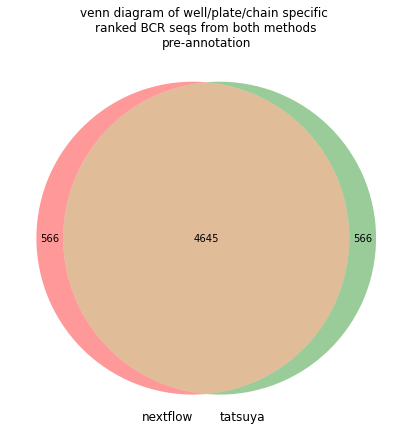

In [20]:
fig, ax = plt.subplots(figsize=[6,6])
unique_bcr_qualities = ["plate", "well","chain", "sequence"]
nf_well_bcrs = set(nextflow_input_bcrs.groupby(unique_bcr_qualities).groups)
tat_well_bcrs = set(tatsuya_input_bcrs.groupby(unique_bcr_qualities).groups)
v = venn2([nf_well_bcrs, tat_well_bcrs], ["nextflow", "tatsuya"], ax=ax)
ax.set_title("venn diagram of well/plate/chain specific \nranked BCR seqs from both methods\npre-annotation")
fig.savefig("input-sequence-differences.png")
plt.tight_layout()
plt.show()

**well, lets make sure the sequences from the same plate/well, have the same count, yea?**

In [21]:
in_both = set.intersection(nf_well_bcrs, tat_well_bcrs)
for rkd_bcr in iter(in_both):
    queries = []
    for i, attr in enumerate(unique_bcr_qualities):
        queries.append(f"({attr} == '{rkd_bcr[i]}')")
    query_string = " & ".join(queries)
    nf_bcr = nextflow_input_bcrs.query(query_string, engine='python')
    tat_bcr = tatsuya_input_bcrs.query(query_string, engine='python')
    assert nf_bcr["count"].values[0] == tat_bcr["count"].values[0]
print("success! Sequences that appear in both methods have the exact same count!")

success! Sequences that appear in both methods have the exact same count!


**Okay, interesting, let's make sure the exlusive BCR's to each pipeline are trivial by making sure counts are low, and this truly is just an ordering issue** 

In [22]:
# compute entire df of the green
tat_but_not_nf = tat_well_bcrs - nf_well_bcrs
tat_but_not_nf_df = tatsuya_input_bcrs.loc[[
    index for index, row in tatsuya_input_bcrs.iterrows()
    if (row.plate, row.well, row.chain, row.sequence) in tat_but_not_nf
]]
tat_but_not_nf_df.head()

,identifier,plate,well,chain,rank,count,sequence
39,211210P01B06H_3-1,P01,B06,H,3.0,1.0,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...
51,211210P01B12H_2-1,P01,B12,H,2.0,1.0,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCCCGTGAAACCTTCTC...
54,211210P01B12K_2-1,P01,B12,K,2.0,1.0,TAGAAAGCGACGGGAGTTCACAGACTGCAACCGGTGTACATTCCGA...
71,211210P01C08H_2-1,P01,C08,H,2.0,1.0,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...
79,211210P01D01H_2-1,P01,D01,H,2.0,1.0,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...


In [23]:
tat_but_not_nf_df.describe()

,rank,count
count,566.000000,566.000000
mean,2.454064,2.432862
std,0.741089,2.316141
min,1.000000,1.000000
25%,2.000000,1.000000
50%,3.000000,1.000000
75%,3.000000,4.000000
max,3.000000,15.000000


In [24]:
# compute entire df of the red
nf_but_not_tat = nf_well_bcrs - tat_well_bcrs
nf_but_not_tat_df = nextflow_input_bcrs.loc[[
    index for index, row in nextflow_input_bcrs.iterrows()
    if (row.plate, row.well, row.chain, row.sequence) in nf_but_not_tat
]]
nf_but_not_tat_df.head()

,identifier,plate,well,chain,rank,count,sequence
2,PR-1-6.211203.P14.B08.K.R.3-6,P14,B08,K,3.0,6.0,GTGTTGATGGAGACATTCTTGATGACTCAGTCTCAAAAATTCATGT...
63,PR-1-6.211203.P14.C06.H.R.3-2,P14,C06,H,3.0,2.0,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...
112,PR-1-6.211203.P14.D01.H.R.3-2,P14,D01,H,3.0,2.0,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...
118,PR-1-6.211203.P14.D02.H.R.3-2,P14,D02,H,3.0,2.0,GAGGTGCAGGTTCAGGAGTCAGGACCAAGCCTCGTGAAACCTTCTC...
121,PR-1-6.211203.P14.D03.H.R.3-2,P14,D03,H,3.0,2.0,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCCTCTC...


In [25]:
nf_but_not_tat_df.describe()

,rank,count
count,566.000000,566.000000
mean,2.416961,2.432862
std,0.761458,2.316141
min,1.000000,1.000000
25%,2.000000,1.000000
50%,3.000000,1.000000
75%,3.000000,4.000000
max,3.000000,15.000000


**okay, moral of the story is that this is just randomness on which horrible BCR's get chosen. We'll also make sure there's nothign weird**

# Post annotation 

## (Tatsuya + IMGT PR1.6)

Data that came from tatsuya doing the demultiplexing and counting "by hand" then annoating using high vquest IMGT tool. We'll be following along with the original steps done in the r markdown for 1.6

### Database generation

* Raw file is an output of the IMGT's high-vquest. Make sure to export AIRR format as well, to make processing simpler (i.e. less files to import for simplicity).

* Process both IgH and IgK at the same time as per PCR strategy.

* below we read in the 

In [26]:
imgt_path = "../2022-01-16-tatsuya-bioinformatics/PR1_6_IMGT_OUT/"
imgt_airr= pd.read_csv("../partis_test/vquest_org.csv")
imgt_airr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5287 entries, 0 to 5286
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   num                 5287 non-null   int64 
 1   ID                  5287 non-null   object
 2   locus               4853 non-null   object
 3   V                   4853 non-null   object
 4   D                   54 non-null     object
 5   J                   4713 non-null   object
 6   Productive          4853 non-null   object
 7   AAjunction          4687 non-null   object
 8   seq_nt              5287 non-null   object
 9   seq_nt_length       5287 non-null   int64 
 10  nt_mut              4853 non-null   object
 11  nt_mut_silent       4853 non-null   object
 12  nt_mut_replacement  4853 non-null   object
 13  aa_replacement      4853 non-null   object
 14  Vchanges            4640 non-null   object
 15  seq_aa              5287 non-null   object
 16  seq_aa_length       5287

# Partis Data

## (Nextflow pipeline + Partis PR1.6)

Data that came from the pipeline then annotated by partis tool.

### Database generation

There is a vast amount of information. The main difference with IMGT is that we are annotating using a custom database for the germline engineered sequences. The AIRR output from partis is split into both IDK and IGH immedietly. We simply append one to the other to make the complete output


**Read and peak at partis data**

In [27]:
partis_output_dir = "../../results/2022-02-09/partis_annotation/PR-1-6/"
partis_igk = pd.read_csv(partis_output_dir+"engrd/single-chain/partition-igk.tsv", sep="\t")
partis_igh = pd.read_csv(partis_output_dir+"engrd/single-chain/partition-igh.tsv", sep="\t")

In [28]:
# partis_igk.info()

In [29]:
partis_igk = partis_igk[partis_igk["seqs_aa"].notna()]
partis_igh = partis_igh[partis_igh["seqs_aa"].notna()]

**Now, we must merge the original sequences in for isotype matching and memo'ization sake**

**partis ends each aa sequence with 'x' because of the extra aa, remove it, let's check and remove if so**

In [30]:
ends_tvss, ends_tvssx, ends_neither = 0, 0, 0
# not_na_heavy = partis_igh[partis_igh["seqs_aa"].notna()]
for seq in partis_igh["seqs_aa"]:
    if seq.endswith("TVSSX"): ends_tvssx += 1
    elif seq.endswith("TVSS"): ends_tvss += 1
    else: ends_neither += 1
print(ends_tvss, ends_tvssx, ends_neither)
for seq in partis_igh["seqs_aa"]:
    assert seq.endswith("X")

0 1962 84


In [31]:
for seq in partis_igk["seqs_aa"]:
    assert not seq.endswith("X")

In [32]:
partis_igh["seq_aa"] = [s[:-1] for s in partis_igh["seqs_aa"]]
partis_igh = partis_igh.drop("seqs_aa", axis=1)
partis_igk = partis_igk.rename({"seqs_aa": "seq_aa"}, axis=1)

In [33]:
len(partis_igh)

2046

In [34]:
print(f"There are {partis_igh.shape[0]+partis_igk.shape[0]} total sequences identified by partis annotation")

There are 5176 total sequences identified by partis annotation


In [35]:
partis_airr = partis_igk.append(partis_igh)

In [36]:
#5176
partis_airr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5176 entries, 0 to 2045
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sequence_id         5176 non-null   object 
 1   sequence            5176 non-null   object 
 2   rev_comp            5176 non-null   object 
 3   productive          5176 non-null   object 
 4   v_call              5176 non-null   object 
 5   d_call              5176 non-null   object 
 6   j_call              5176 non-null   object 
 7   sequence_alignment  5176 non-null   object 
 8   germline_alignment  5176 non-null   object 
 9   junction            5176 non-null   object 
 10  junction_aa         5176 non-null   object 
 11  v_cigar             5176 non-null   object 
 12  d_cigar             5176 non-null   object 
 13  j_cigar             5176 non-null   object 
 14  clone_id            0 non-null      float64
 15  vj_in_frame         5176 non-null   object 
 16  stop_c

In [37]:
to_drop = [
    "j_sequence_end",
    "j_germline_start",
    "j_germline_end",  
    "rev_comp",
    "junction",
    "clone_id",
    "vj_in_frame",
    "stop_codon",
    "np1",
    "np2",
    "duplicate_count",
    "cdr3_start",
    "cdr3_end",
    "cell_id",
    "v_support",
    "v_identity",
    "v_sequence_start",
    "v_sequence_end",
    "v_germline_start",
    "v_germline_end",
    "d_support",
    "d_identity",
    "d_sequence_start",
    "d_sequence_end",
    "d_germline_start",
    "d_germline_end",
    "j_support",
    "j_identity",
    "j_sequence_start",
    "j_sequence_end",
    "j_germline_start",
    "j_germline_end",
]

In [38]:
partis_airr.drop(to_drop, axis=1, inplace=True)

**Format the columns from partis**

In [39]:
# parse the id
partis_airr[
    ['PR_num','date', 'plate_num', 'well', 'chain','_', 'nf_rank_string']
] = partis_airr['sequence_id'].str.split('.', expand=True)
partis_airr["rank"] = [int(r.split("-")[0]) for r in partis_airr["nf_rank_string"]]
partis_airr["counts"] = [int(r.split("-")[1]) for r in partis_airr["nf_rank_string"]]
partis_airr.drop(["nf_rank_string", "_"], axis=1, inplace=True)
partis_airr["ID"] = [
    f"211210{r.plate_num}{r.well}{r.chain}"
    for i, r in partis_airr.iterrows()
]

# TODO f"{r.date}{r.plate_num}{r.well}{r.chain}"

In [40]:
partis_airr["sequence_id"]

0       PR-1-6.211203.P14.B08.K.R.1-375
1        PR-1-6.211203.P14.C11.K.R.2-23
2       PR-1-6.211203.P14.E04.K.R.1-464
3       PR-1-6.211203.P14.E07.H.R.1-293
4        PR-1-6.211203.P14.G01.K.R.2-20
                     ...               
2041      PR-1-6.211203.P06.D11.H.R.3-8
2042     PR-1-6.211203.P06.E11.H.R.3-16
2043     PR-1-6.211203.P06.F12.H.R.3-12
2044     PR-1-6.211203.P06.G11.H.R.3-16
2045      PR-1-6.211203.P06.H11.H.R.3-7
Name: sequence_id, Length: 5176, dtype: object

In [41]:
# trash the unmatched
partis_airr = partis_airr[partis_airr["plate_num"]!="unmatched"]
partis_airr = partis_airr[partis_airr["well"]!="unmatched"]

In [42]:
partis_airr.well.unique()

array(['B08', 'C11', 'E04', 'E07', 'G01', 'H04', 'A12', 'A03', 'B03',
       'A07', 'D08', 'E06', 'F05', 'G06', 'H07', 'A10', 'B12', 'D12',
       'A08', 'C02', 'G04', 'H08', 'B09', 'C12', 'E10', 'F11', 'H02',
       'A02', 'C01', 'D05', 'E03', 'E12', 'A06', 'C05', 'E05', 'F03',
       'H05', 'A01', 'C06', 'C07', 'D01', 'D11', 'E11', 'G02', 'H03',
       'A04', 'F10', 'G09', 'C10', 'D10', 'F09', 'G10', 'B02', 'B05',
       'F06', 'G07', 'B01', 'G05', 'H09', 'F12', 'B10', 'D09', 'D03',
       'F02', 'H10', 'B07', 'G11', 'A09', 'C09', 'D06', 'C08', 'H06',
       'C04', 'H12', 'E01', 'C03', 'F04', 'G03', 'B06', 'B11', 'E08',
       'F07', 'G08', 'F01', 'D02', 'E02', 'H11', 'B04', 'A11', 'E09',
       'F08', 'G12', 'D04', 'A05', 'D07', 'H01'], dtype=object)

In [43]:
row, column = [], []
for w in partis_airr.well.values:
    row.append(w[0])
    column.append(w[1:])
partis_airr["row"] = row
partis_airr["column"] = column

In [44]:
partis_airr.plate_num.unique()

array(['P14', 'P08', 'P12', 'P09', 'P15', 'P11', 'P10', 'P16', 'P07',
       'P13', 'P05', 'P06', 'P01'], dtype=object)

In [45]:
barcode = []
for w in partis_airr.plate_num.values:
    if w == "unmatched":
        barcode.append(np.nan)
    else:
        barcode.append(int(w[1:]))
partis_airr["barcode"] = barcode

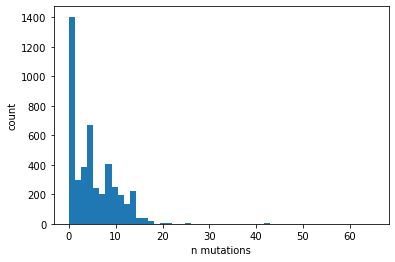

In [46]:
# plt.yscale('log')
plt.hist(partis_airr["n_mutations"], bins=50)
plt.ylabel("count")
plt.xlabel("n mutations")
plt.savefig("hist_n_mutations.png")

In [47]:
# make the equivilent seq_nt column
partis_airr["seq_nt"] = [seq.lower() for seq in partis_airr["sequence"]]
partis_airr["seq_nt_length"] = [len(seq) for seq in partis_airr["seq_nt"]]
partis_airr["seq_aa_length"] = [len(seq) for seq in partis_airr["seq_aa"]]

In [48]:
input_seqs = nextflow_input_bcrs[["identifier", "sequence"]].rename(
    {"identifier":"sequence_id", "sequence":"seq_input"}, axis=1
)
partis_airr = partis_airr.merge(input_seqs, how="left", on="sequence_id")

In [49]:
# rename some things
partis_airr = partis_airr.rename(
    {
        "v_call":"V",
        "d_call":"D",
        "j_call":"J",
        "productive":"Productive",
        "junction_aa":"AAjunction",
    },
    axis=1
)

In [50]:
partis_airr.shape

(4534, 30)

In [51]:
partis_airr.shape

(4534, 30)

In [52]:
partis_airr = partis_airr.convert_dtypes()

In [53]:
# partis_airr.query("ID == '211210P10F03K'")

In [54]:
partis_airr.head()

,sequence_id,sequence,Productive,V,D,J,sequence_alignment,germline_alignment,AAjunction,v_cigar,...,rank,counts,ID,row,column,barcode,seq_nt,seq_nt_length,seq_aa_length,seq_input
0,PR-1-6.211203.P14.B08.K.R.1-375,ACATTCTTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTCG...,True,IGKV6-15*chg,IGKDx-x*x,IGKJ4*chg,ACATTCTTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTCG...,GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAG...,CQQYKNYPITF,287M34I,...,1,375,211210P14B08K,B,08,14,acattcttgatgactcagtctcaaaaattcatgtccacatcagtcg...,321,107,GTGTTGATGGAGACATTCTTGATGACTCAGTCTCAAAAATTCATGT...
1,PR-1-6.211203.P14.C11.K.R.2-23,GACATTGTAATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAG...,False,IGKV6-15*chg,IGKDx-x*x,IGKJ4*chg,GACATTGTAATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAG...,GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAG...,CHQYKSYPLTF,201M1I86M34I,...,2,23,211210P14C11K,C,11,14,gacattgtaatgactcagtctcaaaaattcatgtccacatcagtag...,322,107,GTGTTGATGGAGACATTGTAATGACTCAGTCTCAAAAATTCATGTC...
2,PR-1-6.211203.P14.E04.K.R.1-464,GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAG...,True,IGKV6-15*chg,IGKDx-x*x,IGKJ4*chg,GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAG...,GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAG...,CQQYKTYPITF,287M34I,...,1,464,211210P14E04K,E,04,14,gacattgtgatgactcagtctcaaaaattcatgtccacatcagtag...,321,107,GTGTTGATGGAGACATTGTGATGACTCAGTCTCAAAAATTCATGTC...
3,PR-1-6.211203.P14.E07.H.R.1-293,GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAG...,True,IGKV6-15*chg,IGKDx-x*x,IGKJ4*chg,GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAG...,GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAG...,CHQYKNYPLTF,287M34I,...,1,293,211210P14E07H,E,07,14,gacattgtgatgactcagtctcaaaaattcatgtccacatcagtag...,321,107,TCAGAGCGACGGGAGTTCACAGGTATACATGTTGCTGTGGTTGTCT...
4,PR-1-6.211203.P14.G01.K.R.2-20,GACATTGTGATGTCTCAGTCTCAAAAATTCATGTCCACATCAGTAG...,True,IGKV6-15*chg,IGKDx-x*x,IGKJ4*chg,GACATTGTGATGTCTCAGTCTCAAAAATTCATGTCCACATCAGTAG...,GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAG...,CHQYKNYPLTF,287M34I,...,2,20,211210P14G01K,G,01,14,gacattgtgatgtctcagtctcaaaaattcatgtccacatcagtag...,321,107,GTGTTGATGGAGACATTGTGATGTCTCAGTCTCAAAAATTCATGTC...


## Sequence Lengths

In [55]:
imgt_airr= pd.read_csv("./vquest_na.csv").convert_dtypes()
print(f"There are {len(tatsuya_input_bcrs)} total bcrs from tatsuya input bcr's after removing unmatched")
print(f"There are {len(imgt_airr)} total bcrs from imgt (never removed unmatched)")

There are 5211 total bcrs from tatsuya input bcr's after removing unmatched
There are 5287 total bcrs from imgt (never removed unmatched)


In [56]:
imgt_airr["seq_nt_length"] = [len(s) for s in imgt_airr["seq_nt"]]

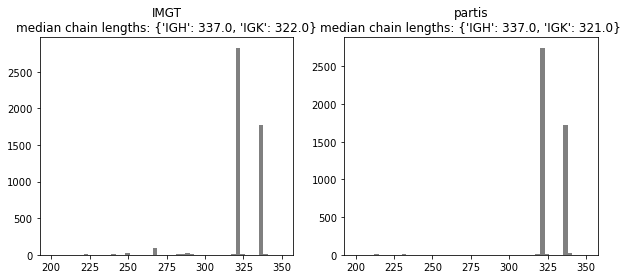

In [57]:
# (should be 336 and 321)

def get_median_chain_length(df):
    medians = {}
    for chain, chain_df in df.groupby("locus"):
        medians[f"{chain}"] = chain_df["seq_nt_length"].median()
    return medians

fig, ax = plt.subplots(1, 2, figsize=[10, 4])
ax[0].hist(imgt_airr["seq_nt_length"], bins=50, range=[200, 350], facecolor='gray', align='mid')
ax[0].set_title(f"IMGT\nmedian chain lengths: {get_median_chain_length(imgt_airr)}")
ax[1].hist(partis_airr["seq_nt_length"], bins=50, range=[200, 350], facecolor='gray', align='mid')
ax[1].set_title(f"partis\nmedian chain lengths: {get_median_chain_length(partis_airr)}")
fig.savefig("sequence_length_hist.png")
plt.show()

In [58]:
imgt_failed_bcrs = imgt_airr.query("(V.isna()) | (well.isna())", engine="python")
imgt_airr = imgt_airr.query("(V.notna()) & (well.notna())", engine="python")
imgt_airr["V"] = [v.split()[1] for v in imgt_airr["V"]]

seq_nts = []
for idx, row in imgt_airr.iterrows():
    seq_nts.append(row.seq_nt[:-1] if row.locus == "IGK" else row.seq_nt)
    
imgt_airr["seq_nt"] = seq_nts
imgt_airr["seq_nt_length"] = [len(s) for s in imgt_airr["seq_nt"]]

imgt_airr_non_v8_15 = imgt_airr.query("(V != 'IGKV6-15*01') & (V != 'IGHV3-8*02')")
imgt_airr = imgt_airr.query("(V == 'IGKV6-15*01') | (V == 'IGHV3-8*02')")

In [59]:
medians = get_median_chain_length(partis_airr)
query_string = "(locus == 'IGH' & seq_nt_length == 337) | (locus == 'IGK' & seq_nt_length == 321)"

# Trim the rest of imgt IGH
imgt_airr = imgt_airr.query(query_string, engine="python")
seq_nts = []
for idx, row in imgt_airr.iterrows():
    seq_nts.append(row.seq_nt[:-1] if row.locus == "IGH" else row.seq_nt)
imgt_airr["seq_nt"] = seq_nts
imgt_airr["seq_nt_length"] = [len(s) for s in imgt_airr["seq_nt"]]


# Trim the rest of partis IGH
partis_airr = partis_airr.query(query_string, engine="python")
seq_nts = []
for idx, row in partis_airr.iterrows():
    seq_nts.append(row.seq_nt[:-1] if row.locus == "IGH" else row.seq_nt)
partis_airr["seq_nt"] = seq_nts
partis_airr["seq_nt_length"] = [len(s) for s in partis_airr["seq_nt"]]

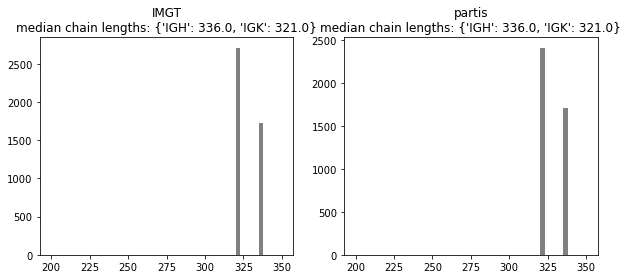

In [60]:
fig, ax = plt.subplots(1, 2, figsize=[10, 4])
ax[0].hist(imgt_airr["seq_nt_length"], bins=50, range=[200, 350], facecolor='gray', align='mid')
ax[0].set_title(f"IMGT\nmedian chain lengths: {get_median_chain_length(imgt_airr)}")
ax[1].hist(partis_airr["seq_nt_length"], bins=50, range=[200, 350], facecolor='gray', align='mid')
ax[1].set_title(f"partis\nmedian chain lengths: {get_median_chain_length(partis_airr)}")
fig.savefig("sequence_length_hist_corrected.png")
plt.show()

In [557]:
imgt_airr.seq_nt_length.value_counts()

321    2713
336    1727
Name: seq_nt_length, dtype: int64

In [558]:
partis_airr.seq_nt_length.value_counts()

321    2410
336    1708
Name: seq_nt_length, dtype: int64

In [61]:
partis_airr.shape

(4118, 30)

## Post Wrangle Summary

In [559]:
print(f"There are {len(imgt_airr)} total bcrs from imgt (removed null wells unmatched)")

There are 4440 total bcrs from imgt (removed null wells unmatched)


In [560]:
for identifier in imgt_airr["ID"]:
    if "unmatched" in identifier:
        print(identifier)
        break

In [561]:
print("-------------------\nIMGT")
print(imgt_airr.info())
print(imgt_airr.describe())
print("-------------------\nPARTIS")
print(partis_airr.info())
print(partis_airr.describe())

-------------------
IMGT
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4440 entries, 1 to 5281
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num                 4440 non-null   Int64  
 1   ID                  4440 non-null   string 
 2   rank                4440 non-null   Int64  
 3   well                4440 non-null   string 
 4   row                 4440 non-null   string 
 5   column              4440 non-null   Int64  
 6   counts              4440 non-null   Int64  
 7   barcode             4440 non-null   Int64  
 8   locus               4440 non-null   string 
 9   V                   4440 non-null   object 
 10  D                   44 non-null     string 
 11  J                   4440 non-null   string 
 12  Productive          4440 non-null   boolean
 13  AAjunction          4440 non-null   string 
 14  seq_nt              4440 non-null   object 
 15  seq_nt_length       4440 non-n

## Post Annotation & Wrangle Sanity Check #1

**Let's make sure our unique sets in the important columns post-cleanup of annotation output is the same.**

In [562]:
imgt_airr.ID[:1]

1    211210P01A01H
Name: ID, dtype: string

In [563]:
partis_airr.ID[:1]

0    211210P14B08K
Name: ID, dtype: string

In [564]:
imgt_airr.barcode.unique()

<IntegerArray>
[1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Length: 13, dtype: Int64

In [565]:
partis_airr.barcode.unique()

<IntegerArray>
[14, 8, 12, 9, 15, 11, 10, 16, 7, 13, 5, 6, 1]
Length: 13, dtype: Int64

In [566]:
partis_airr.column.unique()

<StringArray>
['08', '04', '07', '01', '12', '03', '06', '05', '10', '11', '02', '09']
Length: 12, dtype: string

In [567]:
for group, df in imgt_airr.groupby(["ID", "rank"]):
    assert len(df) == 1
for group, df in partis_airr.groupby(["ID", "rank"]):
    assert len(df) == 1

## Post Annotation & Wrangle Sanity Check #2

**let's check that post annotation we still have outputs/annotations for the wells that we're fed in to the annotation. Because the ID's give us the unique well heavy/light chain, we can just check to see that the set of ID's are the same between the two datasets** 

**The file below is the output of partis telling us exactly which sequences were thrown and why, so that should account for any outstanding differences between the datasets at this point. Below, we show two such sequences**

In [568]:
# ! cat ../../results/2022-02-09/partis_annotation/PR-1-6/engrd/annotate.log | grep "failed for" | head -n 2

In [569]:
# ! cat ../../results/2022-02-09/partis_annotation/PR-1-6/engrd/annotate.log | grep "failed for" > "failed_queries.log"

In [570]:
# failed_partis_ids = []
# with open("failed_queries.log", "r") as failed_in_partis:
#     for line in failed_in_partis:
#         failed_pr = re.findall(r"\[\'(.*?)\'\]", line.strip())
#         attrib = parse_nextflow_header(failed_pr[0])
#         if attrib != -1:
#             failed_partis_ids.append("211210" + attrib["plate"] + attrib["well"] + attrib["chain"])
# print(len(failed_partis_ids))

**let's parse this and get summarize those which were thrown out**

In [571]:
partis_failed_bcrs = bcr_fasta_to_df(
    "../../results/2022-02-09/partis_annotation/PR-1-6/engrd/failed.fa",
    parse_nextflow_header
).infer_objects()
partis_failed_bcrs.head()

,identifier,plate,well,chain,rank,count,sequence
0,PR-1-6.211203.P14.C08.K.R.1-1,P14,C08,K,1.0,1.0,GATGCTGCTCCAACTGTATCCATCTAATTAGCGTGAAGATCGGAAG...
1,PR-1-6.211203.P14.E04.H.R.1-1,P14,E04,H,1.0,1.0,CAAATGTCTTCCCCCTTAATTAGCGTTAAGATCGGAAGAGCGGTTC...
2,PR-1-6.211203.P14.G06.K.R.1-1,P14,G06,K,1.0,1.0,CACCAACTGTATCCATCTAATTAGCGTTCAGATCGGAAGAGCGGTT...
3,PR-1-6.211203.P14.G06.K.R.2-1,P14,G06,K,2.0,1.0,CACCAACTGTATCCATCTAATTAGCGTTAAGATCGGAAGAGCGGTT...
4,PR-1-6.211203.P14.G06.K.R.3-1,P14,G06,K,3.0,1.0,CACCAACTGTATCCATCTAATTAGCGTTTAGATCGGAAGAGCGGTT...


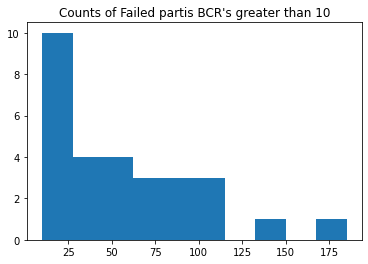

In [572]:
plt.hist(partis_failed_bcrs.query("count >= 10")["count"])
plt.title("Counts of Failed partis BCR's greater than 10")
plt.savefig("failed_partis.png")

In [573]:
# failed_v_imgt_failed_bcrs # failed V or well
# imgt_airr_non_v8_15 # non V in 8 or 15


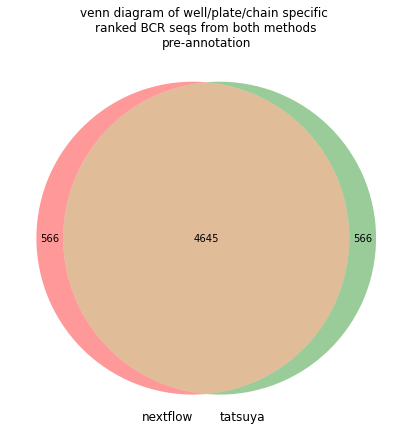

In [574]:
fig, ax = plt.subplots(figsize=[6,6])
unique_bcr_qualities = ["plate", "well","chain", "sequence"]
nf_well_bcrs = set(nextflow_input_bcrs.groupby(unique_bcr_qualities).groups)
tat_well_bcrs = set(tatsuya_input_bcrs.groupby(unique_bcr_qualities).groups)
v = venn2([nf_well_bcrs, tat_well_bcrs], ["nextflow", "tatsuya"], ax=ax)
ax.set_title("venn diagram of well/plate/chain specific \nranked BCR seqs from both methods\npre-annotation")
fig.savefig("input-sequence-differences.png")
plt.tight_layout()
plt.show()

## "effective sequence duplicates"

In [449]:
for uniq_well_bcr, df in imgt_airr.groupby(["ID", "seq_nt"]):
    if len(df) != 1:
        print(df)
        break

   num             ID  rank well row  column  counts  barcode locus  \
1    1  211210P01A01H     1  A01   A       1       1        1   IGH   
2    2  211210P01A01H     2  A01   A       1       1        1   IGH   

            V  ... aa_replacement  \
1  IGHV3-8*02  ...              5   
2  IGHV3-8*02  ...              5   

                                            Vchanges  \
1  a143>g,N48>S(- - -); N48 aat 142-144 [aa 142-1...   
2  a143>g,N48>S(- - -); N48 aat 142-144 [aa 142-1...   

                                              seq_aa seq_aa_length  \
1  EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGSKLE...           112   
2  EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGSKLE...           112   

                                           seq_input  \
1  gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctc...   
2  gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctc...   

                                       gapped seq_nt  \
1  gaggtgcagcttcaggagtcaggacct...agcctcgtgaaacctt...   
2  gaggtgcagc

**Looks like there are duplicates in well's? They're ranked the same but they're "effective" duplicates - these do not appear in the input fasta's, obviously. How much is this effecting things? Let's take a look**

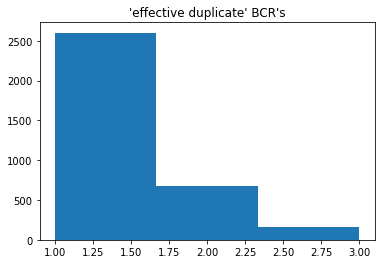

In [450]:
duplicate_bcr_counts = []
for uniq_well_bcr, df in imgt_airr.groupby(["ID", "seq_nt"]):
    duplicate_bcr_counts.append(len(df))
plt.title("'effective duplicate' BCR's")
plt.hist(duplicate_bcr_counts, bins=3)
plt.savefig("hist_num_effective_duplicates.png")
plt.show()

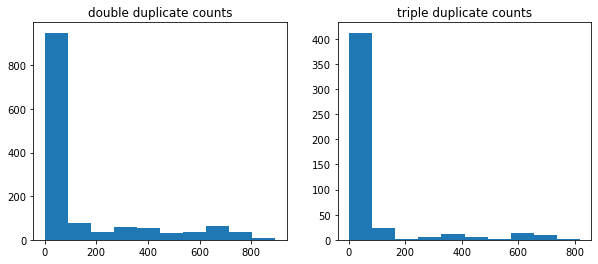

In [451]:
fi, ax = plt.subplots(1, 2, figsize=[10, 4])
double_counts, triple_counts = [], []
for uniq_well_bcr, df in imgt_airr.groupby(["ID", "seq_nt"]):
    if len(df) == 2:
        double_counts.extend(df["counts"].values)
    elif len(df) == 3:
        triple_counts.extend(df["counts"].values)
    else:
        continue
ax[0].set_title("double duplicate counts")
ax[0].hist(double_counts)
ax[1].set_title("triple duplicate counts")
ax[1].hist(triple_counts)
fig.savefig("counts_dist_dup_trip.png")
plt.show()

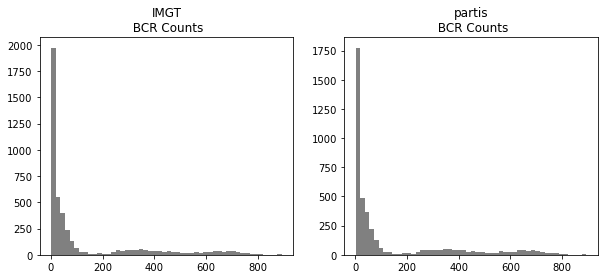

In [452]:
fig, ax = plt.subplots(1, 2, figsize=[10, 4])
ax[0].hist(imgt_airr["counts"], bins=50, facecolor='gray', align='mid')
ax[0].set_title(f"IMGT\n BCR Counts")
ax[1].hist(partis_airr["counts"], bins=50, facecolor='gray', align='mid')
ax[1].set_title(f"partis\n BCR Counts")
fig.savefig("sequence_count_hist.png")
plt.show()

In [453]:
partis_collapsed_effective = partis_airr.groupby(
    ["ID", "seq_nt"]).sum()

In [454]:
imgt_collapsed_effective = imgt_airr.groupby(
    ["ID", "seq_nt"]).sum()

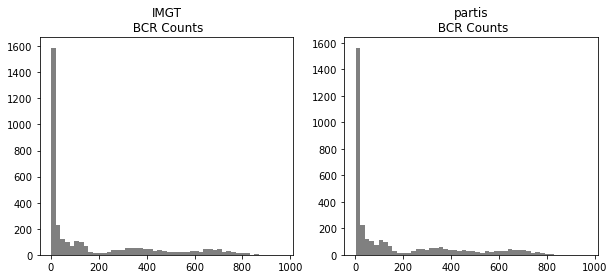

In [455]:
fig, ax = plt.subplots(1, 2, figsize=[10, 4])
ax[0].hist(imgt_collapsed_effective["counts"], bins=50, facecolor='gray', align='mid')
ax[0].set_title(f"IMGT\n BCR Counts")
ax[1].hist(partis_collapsed_effective["counts"], bins=50, facecolor='gray', align='mid')
ax[1].set_title(f"partis\n BCR Counts")
fig.savefig("sequence_count_hist_agg_dups.png")
plt.show()

In [456]:
# len(partis_airr[partis_airr["counts"]>=10])

In [457]:
# len(imgt_collapsed_effective[imgt_collapsed_effective["counts"]>=10])

In [458]:
imgt_collapsed_effective_imgt

num  rank  \
ID            seq_nt                                                            
211210P01A01H gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...      3     3   
211210P01A02H gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...      4     2   
              gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...      3     1   
211210P01A02K gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...      6     2   
              gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...      5     1   
...                                                                 ...   ...   
211210P16H12H gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...  10553     3   
              gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...   5278     3   
211210P16H12K gacattgtgatgactcagtctcaaaaattcatgtccacatcagtagg...   5279     1   
              gacattgtgatgactcagtctcaaaaattcatgtccacatcagtagg...   5280     2   
              gacattgtgatgactcagtctcaaaaattcatgtccacatcagtagg...   5281     3   

                                                                  column  \
ID            seq_nt                                                       
211210P01A01H gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...       2   
211210P01A02H gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...       2   
              gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...       2   
211210P01A02K gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...       2   
              gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...       2   
...                                                                  ...   
211210P16H12H gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...      24   
              gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...      12   
211210P16H12K gacattgtgatgactcagtctcaaaaattcatgtccacatcagtagg...      12   
              gacattgtgatgactcagtctcaaaaattcatgtccacatcagtagg...      12   
              gacattgtgatgactcagtctcaaaaattcatgtccacatcagtagg...      12   

                                                                  counts  \
ID            seq_nt                                                       
211210P01A01H gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...       2   
211210P01A02H gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...       1   
              gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...       1   
211210P01A02K gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...       1   
              gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...       1   
...                                                                  ...   
211210P16H12H gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...     112   
              gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...       6   
211210P16H12K gacattgtgatgactcagtctcaaaaattcatgtccacatcagtagg...     268   
              gacattgtgatgactcagtctcaaaaattcatgtccacatcagtagg...     149   
              gacattgtgatgactcagtctcaaaaattcatgtccacatcagtagg...      31   

                                                                  barcode  \
ID            seq_nt                                                        
211210P01A01H gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...        2   
211210P01A02H gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...        1   
              gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...        1   
211210P01A02K gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...        1   
              gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...        1   
...                                                                   ...   
211210P16H12H gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...       32   
              gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctca...       16   
211210P16H12K gacattgtgatgactcagtctcaaaaattcatgtccacatcagtagg...       16   
              gacattgtgatgactcagtctcaaaaattcatgtccacatcagtagg...       16   
              gacattgtgatgactcagtctcaaaaattcatgtccacatcagtagg...       16   

                                  

In [463]:
print(imgt_collapsed_effective_imgt.shape)

(3440, 8)


**Effective duplicates accounts for a few major sequences which are identical but counted as separate!**

## Sequence differences

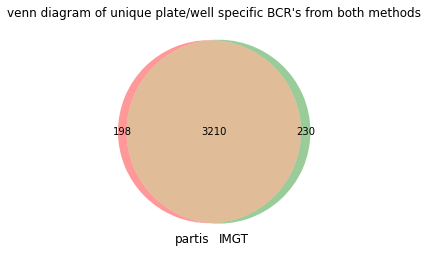

In [469]:
nf_partis_ranked_seqs = set(partis_airr.groupby(["ID", "seq_nt"]).groups)
tat_imgt_ranked_seqs = set(imgt_airr.groupby(["ID", "seq_nt"]).groups)
v = venn2([nf_partis_ranked_seqs, tat_imgt_ranked_seqs], ["partis", "IMGT"])
plt.title("venn diagram of unique plate/well specific BCR's from both methods")
plt.savefig("post_annotation_bcr_differences_no_thresh.png")
plt.show()

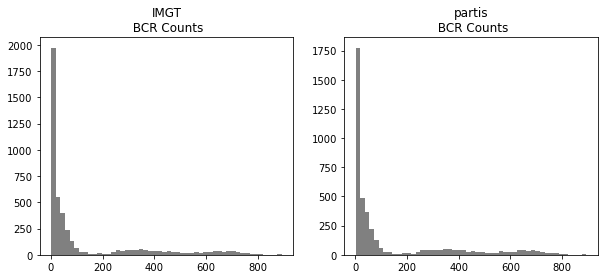

In [465]:
fig, ax = plt.subplots(1, 2, figsize=[10, 4])
ax[0].hist(imgt_airr["counts"], bins=50, facecolor='gray', align='mid')
ax[0].set_title(f"IMGT\n BCR Counts")
ax[1].hist(partis_airr["counts"], bins=50, facecolor='gray', align='mid')
ax[1].set_title(f"partis\n BCR Counts")
fig.savefig("sequence_count_hist.png")
plt.show()

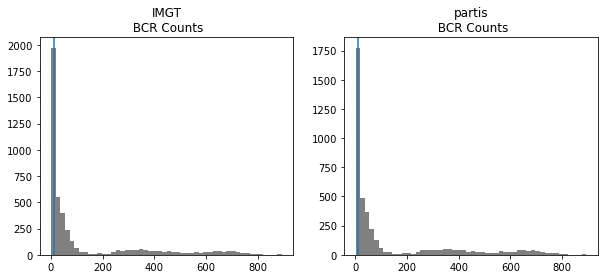

In [466]:
fig, ax = plt.subplots(1, 2, figsize=[10, 4])
ax[0].hist(imgt_airr["counts"], bins=50, facecolor='gray', align='mid')
ax[0].set_title(f"IMGT\n BCR Counts")
ax[0].axvline(10)
ax[1].hist(partis_airr["counts"], bins=50, facecolor='gray', align='mid')
ax[1].set_title(f"partis\n BCR Counts")
ax[1].axvline(10)

fig.savefig("sequence_count_hist.png")
plt.show()

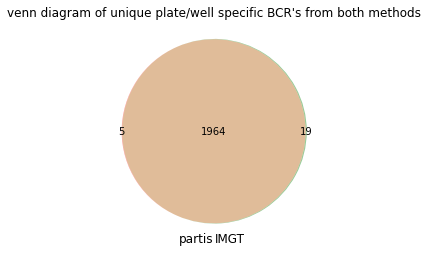

In [510]:
nf_partis_ranked_seqs = set(
    partis_airr.query("counts >= 16 & Productive == True", engine="python").groupby(["ID", "seq_nt"]).groups
)
tat_imgt_ranked_seqs = set(
    imgt_airr.query("counts >= 16 & Productive == True", engine="python").groupby(["ID", "seq_nt"]).groups
)
v = venn2([nf_partis_ranked_seqs, tat_imgt_ranked_seqs], ["partis", "IMGT"])
plt.title("venn diagram of unique plate/well specific BCR's from both methods")
plt.savefig("post_annotation_bcr_differences_w_thresh.png")
plt.show()

In [477]:
imgt_but_not_partis = (tat_imgt_ranked_seqs - nf_partis_ranked_seqs) 
imgt_but_not_partis_df = imgt_airr.loc[[
    index for index, row in imgt_airr.iterrows()
    if (row.ID, row.seq_nt) in imgt_but_not_partis
]]
imgt_but_not_partis_df.columns

Index(['num', 'ID', 'rank', 'well', 'row', 'column', 'counts', 'barcode',
       'locus', 'V', 'D', 'J', 'Productive', 'AAjunction', 'seq_nt',
       'seq_nt_length', 'nt_mut', 'nt_mut_silent', 'nt_mut_replacement',
       'aa_replacement', 'Vchanges', 'seq_aa', 'seq_aa_length', 'seq_input',
       'gapped seq_nt', 'gapped seq_aa', 'v_cigar', 'd_cigar', 'j_cigar'],
      dtype='object')

In [513]:
imgt_but_not_partis_df[imgt_but_not_partis_df["counts"]>=100]

,num,ID,rank,well,row,column,counts,barcode,locus,V,...,aa_replacement,Vchanges,seq_aa,seq_aa_length,seq_input,gapped seq_nt,gapped seq_aa,v_cigar,d_cigar,j_cigar
2756,2756,211210P10F03K,1,F03,F,3,735,10,IGK,IGKV6-15*01,...,2,"c15>t, T5; T5 acc 13-15>T act|g154>a,A52>T(- -...",DIVMTQSQKFMSTSVGDRVSVTCKASQNVGTNVAWYQQKPGQSPKT...,107,gtgttgatggagacattgtgatgactcagtctcaaaaattcatgtc...,gacattgtgatgactcagtctcaaaaattcatgtccacatcagtag...,DIVMTQSQKFMSTSVGDRVSVTCKASQNV......GTNVAWYQQKP...,11S14=1X120=1X23=1X120=1X6=76S,<NA>,298S3N18=2X1=2X1=1X10=41S
4864,4864,211210P16B09K,1,B09,B,9,388,16,IGK,IGKV6-15*01,...,4,"c15>t, T5; T5 acc 13-15>T act|c199>a, R67; R67...",DIVMTQSQKFMSTSVGDRVSVTCKASQNVGTNVAWYQQKPGQSPKA...,107,gtgttgatggagacattgtgatgactcagtctcaaaaattcatgtc...,gacattgtgatgactcagtctcaaaaattcatgtccacatcagtag...,DIVMTQSQKFMSTSVGDRVSVTCKASQNV......GTNVAWYQQKP...,11S14=1X144=1X8=1X13=1X80=1X11=1X2=1X8=74S,<NA>,298S3N18=1X2=1X2=1X10=39S
4970,4970,211210P16D04K,1,D04,D,4,127,16,IGK,IGKV6-15*01,...,4,"c15>t, T5; T5 acc 13-15>T act|a117>g, V39; V39...",DIVMTQSQKFMSTSVGDRVSVTCKASQNVGTNVAWHQQKPGQSPKA...,107,gtgttgatggagacattgtgatgactcagtctcaaaaattcatgtc...,gacattgtgatgactcagtctcaaaaattcatgtccacatcagtag...,DIVMTQSQKFMSTSVGDRVSVTCKASQNV......GTNVAWHQQKP...,11S14=1X83=1X6=1X16=1X23=1X11=4X78=1X13=1X18=1...,<NA>,297S2N19=2X1=2X1=1X10=39S
5173,5173,211210P16G05K,1,G05,G,5,648,16,IGK,IGKV6-15*01,...,8,"c15>t, T5; T5 acc 13-15>T act|a42>g, S14; S14 ...",DIVMTQSQKFMSTSVGDRVSVTCKASQNVGTNVGWYQQKPGQSPKA...,107,gtgttgatggagacattgtgatgactcagtctcaaaaattcatgtc...,gacattgtgatgactcagtctcaaaaattcatgtccacatcggtag...,DIVMTQSQKFMSTSVGDRVSVTCKASQNV......GTNVGWYQQKP...,11S14=1X26=1X47=1X10=1X21=1X36=2X26=1X26=1X11=...,<NA>,299S5N8=1X8=1X5=1X10=39S
5280,5280,211210P16H12K,2,H12,H,12,149,16,IGK,IGKV6-15*01,...,8,"c15>t, T5; T5 acc 13-15>T act|t108>a, G36; G36...",DIVMTQSQKFMSTSVGDRVSVTCKASQNVGTNVGWYQQKPGQSPKA...,107,gtgttgatggagacattgtgatgactcagtctcaaaaattcatgtc...,gacattgtgatgactcagtctcaaaaattcatgtccacatcagtag...,DIVMTQSQKFMSTSVGDRVSVTCKASQNV......GTNVGWYQQKP...,11S14=1X74=1X10=1X21=1X36=2X26=1X26=1X11=1X24=...,<NA>,299S5N8=1X8=1X5=1X10=39S


In [514]:
partis_airr.query("ID == '211210P10F03K'")

,sequence_id,sequence,Productive,V,D,J,sequence_alignment,germline_alignment,AAjunction,v_cigar,...,chain,rank,counts,ID,row,column,barcode,seq_nt,seq_nt_length,seq_aa_length


In [502]:
partis_failed_bcrs["seq_input"] = [s.lower() for s in partis_failed_bcrs["sequence"]]
partis_failed_bcrs["barcode"] = [int(p[1:]) for p in partis_failed_bcrs["plate"]]
partis_failed_bcrs["ID"] = [f"211210{row.plate}{row.well}{row.chain}" for idx, row in partis_failed_bcrs.iterrows()]
partis_failed_bcrs = partis_failed_bcrs.infer_objects()

In [503]:
partis_failed_bcrs.head()

,identifier,plate,well,chain,rank,count,sequence,seq_input,barcode,ID
0,PR-1-6.211203.P14.C08.K.R.1-1,P14,C08,K,1.0,1.0,GATGCTGCTCCAACTGTATCCATCTAATTAGCGTGAAGATCGGAAG...,gatgctgctccaactgtatccatctaattagcgtgaagatcggaag...,14,211210P14C08K
1,PR-1-6.211203.P14.E04.H.R.1-1,P14,E04,H,1.0,1.0,CAAATGTCTTCCCCCTTAATTAGCGTTAAGATCGGAAGAGCGGTTC...,caaatgtcttcccccttaattagcgttaagatcggaagagcggttc...,14,211210P14E04H
2,PR-1-6.211203.P14.G06.K.R.1-1,P14,G06,K,1.0,1.0,CACCAACTGTATCCATCTAATTAGCGTTCAGATCGGAAGAGCGGTT...,caccaactgtatccatctaattagcgttcagatcggaagagcggtt...,14,211210P14G06K
3,PR-1-6.211203.P14.G06.K.R.2-1,P14,G06,K,2.0,1.0,CACCAACTGTATCCATCTAATTAGCGTTAAGATCGGAAGAGCGGTT...,caccaactgtatccatctaattagcgttaagatcggaagagcggtt...,14,211210P14G06K
4,PR-1-6.211203.P14.G06.K.R.3-1,P14,G06,K,3.0,1.0,CACCAACTGTATCCATCTAATTAGCGTTTAGATCGGAAGAGCGGTT...,caccaactgtatccatctaattagcgtttagatcggaagagcggtt...,14,211210P14G06K


In [508]:
imgt_but_not_partis_df.locus.unique()

<StringArray>
['IGK']
Length: 1, dtype: string

(array([13.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([16.0, 51.95, 87.9, 123.85000000000001, 159.8, 195.75,
        231.70000000000002, 267.65000000000003, 303.6, 339.55, 375.5,
        411.45000000000005, 447.40000000000003, 483.35, 519.3000000000001,
        555.25, 591.2, 627.1500000000001, 663.1, 699.0500000000001, 735.0],
       dtype=object),
 <BarContainer object of 20 artists>)

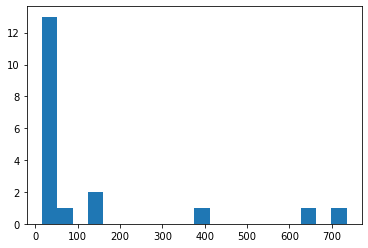

In [505]:
plt.hist(imgt_but_not_partis_df.counts.values, bins=20)

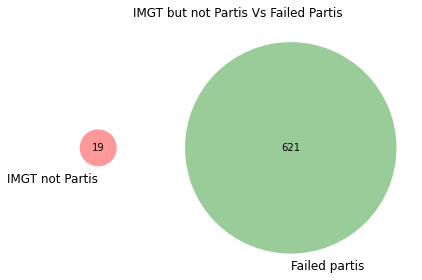

In [506]:
# unique_bcr_qualities = ["plate", "well","chain", "sequence"]
fig, ax = plt.subplots(figsize=[6,6])

imgt_not_partis = set(imgt_but_not_partis_df.groupby(["ID", "seq_input"]).groups)
failed_partis = set(partis_failed_bcrs.groupby(["ID", "seq_input"]).groups)
v = venn2([imgt_not_partis, failed_partis], ["IMGT not Partis", "Failed partis"], ax=ax)
ax.set_title("IMGT but not Partis Vs Failed Partis")
fig.savefig("imgt_failed_parti.png")
plt.tight_layout()
plt.show()

In [472]:
partis_but_not_imgt = (nf_partis_ranked_seqs - tat_imgt_ranked_seqs) 
partis_but_not_imgt_df = partis_airr.loc[[
    index for index, row in partis_airr.iterrows()
    if (row.ID, row.seq_nt) in partis_but_not_imgt
]]
partis_but_not_imgt_df.describe()

,Productive,n_mutations,rank,counts,barcode,seq_nt_length,seq_aa_length
count,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
unique,1,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,10,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,19.000000,2.100000,160.100000,11.300000,328.500000,109.500000
std,NaN,17.042431,0.875595,236.502972,3.831159,7.905694,2.635231
min,NaN,1.000000,1.000000,5.000000,5.000000,321.000000,107.000000
25%,NaN,6.250000,1.250000,14.000000,9.750000,321.000000,107.000000
50%,NaN,14.500000,2.000000,23.500000,12.000000,328.500000,109.500000
75%,NaN,36.500000,3.000000,301.500000,13.750000,336.000000,112.000000


In [1540]:
# exclusive_imgt_input_seqs = [s.lower() for s in tat_but_not_nf_df["sequence"].values]
# partis_failed_seqs = [s.lower() for s in partis_failed_bcrs["sequence"].values]
# partis_trash_or_low_rank = exclusive_imgt_input_seqs + partis_failed_seqs
# not_found_in_partis = imgt_but_not_partis_df[~imgt_but_not_partis_df["seq_input"].isin(partis_trash_or_low_rank)]

## Simulate rank N pulling of the sequences

In [ ]:
# Going to have to get all collapsed fastas from the cluster

# Then you're going to want to do head vs grep -rank (??) on each, this may be slow locally but ... whatever. 

# Just alpha the regular distributions, or maybe a fancy split violin plot, 

# basically populate a tall dataframe.

# then plotnine that mf

## Infer Isotype through motif matching


```
# Initialize isotype column
vquest <- vquest %>% 
  mutate(isotype = "to be filled", .after = J)

# For LC fill in "IGK" and identify the isotypes for the HC
for (i in 1:length(vquest$seq_input)) {
  if (vquest$locus[i] == "IGK") {
    vquest$isotype[i] <- "IgK"
  } else if("atgtcttccccct" %in% str_extract(vquest$seq_input[i], "atgtcttccccct")) {
    vquest$isotype[i] <- "IgM"
  } else if ("atggtgaccctggg" %in% str_extract(vquest$seq_input[i], "atggtgaccctggg")) {
    vquest$isotype[i] <- "IgG1"
  } else if ("ggctcctcggtgactcta" %in% 
             str_extract(vquest$seq_input[i], "ggctcctcggtgactcta") |
             "tcggtgactctagg" %in% str_extract(vquest$seq_input[i], "tcggtgactctagg") |
             "gtgtggagatacaactgg" %in% 
             str_extract(vquest$seq_input[i], "gtgtggagatacaactgg")) {
    vquest$isotype[i] <- "IgG2"
  } else if ("cccttggtccctggctgcggtgacacat" %in% 
             str_extract(vquest$seq_input[i], "cccttggtccctggctgcggtgacacat") |
             "cacatctggatcctcggtgaca" %in% 
             str_extract(vquest$seq_input[i], "cacatctggatcctcggtgaca")) {
    vquest$isotype[i] <- "IgG3"
  } else if ("tctgcgagaaatcccaccatcta" %in% 
             str_extract(vquest$seq_input[i], "tctgcgagaaatcccaccatcta")) {
    vquest$isotype[i] <- "IgA"
  } else (vquest$isotype[i] <- "error")
}

print("done") #if evaluated
```